In [1]:
#Importing Libraries
from Plots import *
from Auxiliar_Functions import *
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import time    
from IPython.display import HTML

## Table of Contents:
* [1.EDOs](#first-bullet)
* [2.Results](#second-bullet)
    * [2.1 - Comparing Energies and M.O.](#2.1-bullet)
    * [2.2 - Comparing Angular Cases](#2.2-bullet)
    * [2.3 - Without Slow ($\omega= 0$)](#2.3-bullet)
* [3.Comparing Numerical Solvers](#3-bullet)

# Angular Distribution

In [2]:
def angular_dist_Ian(theta,a,b):
    return 0.45 - a +(0.1/b)*np.exp(-1*(1-np.cos(theta))**2/(2*b**2))

def theta_dist(theta,nu_type,case):
    if nu_type=="nu_x" or nu_type=="nu_x_bar":
        return np.where(theta<-100,0.0,0.0)
    
    # New Developments in Flavor Evolution of a Dense Neutrino Gas - Irene Tamborra, Shashank Shalgar
    #https://arxiv.org/abs/2011.01948
    if case==1:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/3,1,0.25)
    elif case==2:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/4,1,0.5)
    elif case==3:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/3,0.5*1.5,0.5)
        
    #Neutrino Flavor Pendulum Reloaded: The Case of Fast Pairwise Conversion - Padilla-Gay, Irene Tamborra, Georg G. Raffelt 
    # https://arxiv.org/abs/2109.14627
    elif case=='A':
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return angular_dist_Ian(theta,0,0.4)
    elif case=='B':
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return angular_dist_Ian(theta,0.02,0.4)       
    elif case=='C':
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return angular_dist_Ian(theta,0.02,0.6)
    elif case=='D':
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return angular_dist_Ian(theta,0.06,0.2)
    
    else:
        print("Not a valid angular distribution!")


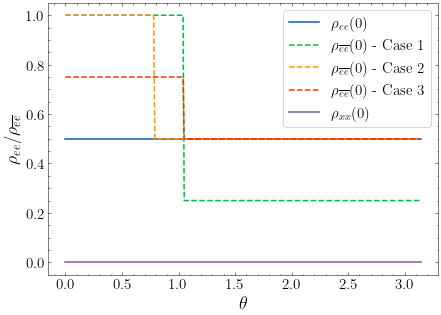

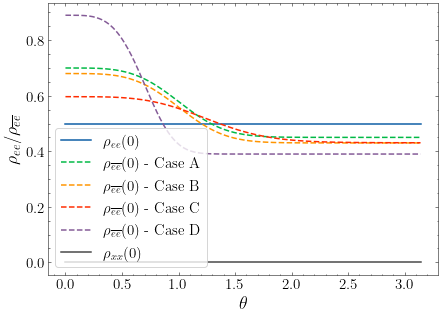

In [3]:
theta_vec=np.arange(0,math.pi,0.01)
plt.figure(figsize=(7,5))
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e",1),label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",1),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 1")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",2),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 2")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",3),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 3")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_x",1),label=r"$\rho_{xx}(0)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e",'A'),label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",'A'),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case A")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",'B'),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case B")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",'C'),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case C")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",'D'),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case D")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_x",'A'),label=r"$\rho_{xx}(0)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

# 1. EDOs <a class="anchor" id="first-bullet"></a>

In [4]:
def initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case):
    y0=[] #Initial state
    flavor_sign=[1,-1]
    omega=delta_m2/(2*E_nu*10**6) #eV 
    rho_ex=0
    if delta_m2==0:
        rho_ex=10**-7

    cos_theta_vec=np.linspace(-1,1,theta_bins)
    cos_theta_step=cos_theta_vec[1]-cos_theta_vec[0]
    n_theta=len(cos_theta_vec)
    n_f=len(nu_types)
    n_dim=(n_f**2)-1
    n_antipart=2

    index_order=[n_theta,n_f,n_dim,n_antipart]
    
    for i in range(n_theta):        
      for j in range(n_f):
        #nu
        nu_spec=theta_dist(np.arccos(cos_theta_vec[i]),nu_types[j],case)*cos_theta_step
        y0.append(rho_ex)
        y0.append(rho_ex)
        y0.append(flavor_sign[j]*nu_spec)
        #nubar
        nu_spec=theta_dist(np.arccos(cos_theta_vec[i]),nu_types[j]+'_bar',case)*cos_theta_step
        y0.append(rho_ex)
        y0.append(rho_ex)
        y0.append(flavor_sign[j]*nu_spec)

    #t array
    t_i = t_i*c_const*from_eV_to_1_over_m #from s to eV⁻¹
    t_f = t_f*c_const*from_eV_to_1_over_m #from s to eV⁻¹
    t_step=(2*np.pi/max(omega,mu_0))/30
    t = np.arange(t_i,t_f,t_step) #eV⁻¹

    return y0,omega,E_nu,t,mu_0,n_f,n_dim,n_theta,cos_theta_vec

In [5]:
def from_1D_to_MultiD(y,n_f,n_dim,n_theta):
    nu, nubar = [],[]    
    #Filling [Theta bin][Nu_Flavors][3components]    
    for i in range(n_theta):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*2*n_dim*n_f)+(j*2*n_dim)+k
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*2*n_dim*n_f)+(j*2*n_dim)+(k+n_dim)
          nubar[i][j].append(y[nubar_index])
    return nu, nubar 

In [6]:
def func_Collective_nu_v2(y, time, params):
    omega,E,theta_V,mu_0,n_f,n_dim,n_theta,cos_theta_vec= params  # unpack parameters
    
    B=np.array(B_vec(n_dim,theta_V))
    L=np.array(L_vec(n_dim))
    mu=mu_0
    lamb=lambda_supernova(time,"no",0)

    derivs=[]
    nu, nubar = from_1D_to_MultiD(y,n_f,n_dim,n_theta)
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,0,1))
    nubar_aux=np.transpose(nubar,(2,0,1))

    for i in range(n_dim):
      nu_sum.append(sum(map(sum,nu_aux[i])))
      nubar_sum.append(sum(map(sum,nubar_aux[i])))
      nu_sum_theta.append(sum(cos_theta_vec*list(map(sum,nu_aux[i]))))
      nubar_sum_theta.append(sum(cos_theta_vec*list(map(sum,nubar_aux[i]))))
    
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-cos_theta_vec[i]*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-cos_theta_vec[i]*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [7]:
def solver_two_families_v2(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord):
    y0,omega,E,t,mu_0,n_f,n_dim,n_theta,cos_theta_vec=initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case)
    
    if mass_ord=="NH": 
        params=omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    elif mass_ord=="IH":
        params=-1*omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    else:
        print("Not a mass ordering option!")
    psoln= odeint(func_Collective_nu_v2, y0, t, args=(params,))

    nu, nubar= read_output(psoln,(n_f,n_dim,n_theta))    
    t=t/(c_const*from_eV_to_1_over_m) #From eV⁻¹ to km

    return cos_theta_vec,t,mu_0, nu, nubar

# 2. Resuts <a class="anchor" id="second-bullet"></a>

## 2.1 - Comparing Energies and M.O. <a class="anchor" id="2.1-bullet"></a>

In [57]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["IH",1,1],["NH",1,1],["NH",1,10],["NH",1,10**4]]
# scenarios=[["IH",1,1]]
mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,5*10**(-6) #s
theta_bins=100
theta_step=np.pi/theta_bins
cos_theta_step=2/theta_bins

print("mu=%.1e eV = %.1e s⁻¹"%(mu_0,mu_0*from_eV_to_1_over_m*3*10**8))
for mass_ord,case,E_nu in scenarios:
    print("w=%.1e eV =%.1e s⁻¹= %.1e km⁻¹"%(delta_m2_31/(2*E_nu*10**6),delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_m*3*10**8,delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_km))
# print("T_vac=%.1e s"%(2*np.pi/(delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_m*3*10**8)))
# print("t_step=%.1e s"%(t_f/1000))
# print("f_sampling = %.1e s⁻¹"%(1/(t_f/5000)))
# print("t_f=%.1e km"%(t_f*3*10**5))

mu=2.0e-07 eV = 3.0e+08 s⁻¹
w=1.3e-09 eV =1.9e+06 s⁻¹= 6.3e+00 km⁻¹
w=1.3e-09 eV =1.9e+06 s⁻¹= 6.3e+00 km⁻¹
w=1.3e-10 eV =1.9e+05 s⁻¹= 6.3e-01 km⁻¹
w=1.2e-13 eV =1.9e+02 s⁻¹= 6.3e-04 km⁻¹


In [58]:
nu,nubar=[],[]
for mass_ord,case,E_nu in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v2(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord)
    print("Took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)

Took 1.2556457996368409 minutes
Took 0.6642944971720378 minutes
Took 0.5159367005030314 minutes
Took 1.0702581683794656 minutes


In [59]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]

for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu,(0,1,2,4,3))[i][0][0]**2+np.transpose(nu,(0,1,2,4,3))[i][1][0]**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
#     rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*theta_step/np.pi)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*cos_theta_step/2)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu,(0,1,2,4,3))[i][2][0][j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
#     P_ex_mean_time.append(sum(P_ex_theta_time_aux)*theta_step/np.pi)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*cos_theta_step/2)

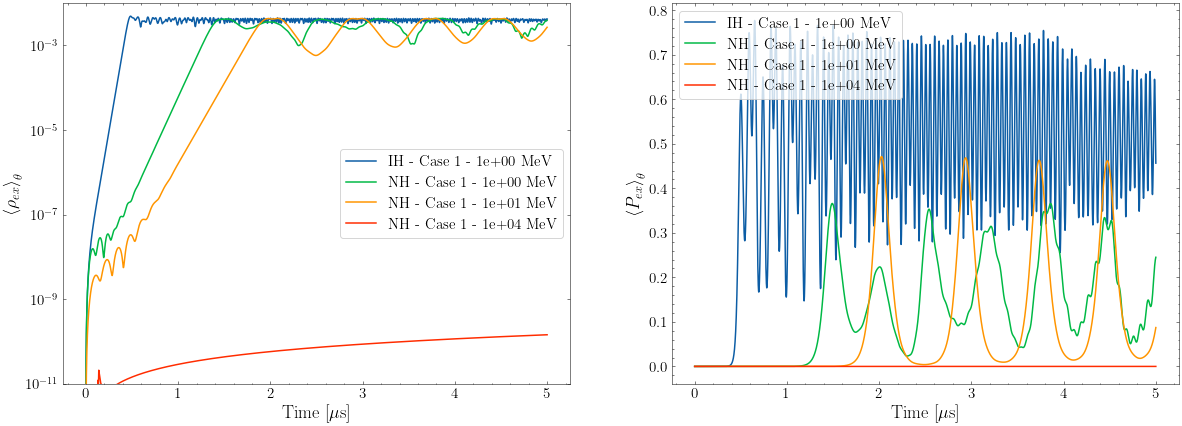

In [60]:
x_min,x_max=0,5*10**-6

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
for i in range(len(scenarios)):
    plt.plot((10**6)*t,rho_ex_mean_time[i],label="%s - Case %d - %.0e MeV"%(scenarios[i][0],scenarios[i][1],scenarios[i][2]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
plt.ylim(10**-11,10**-2)
# plt.xlim(x_min,x_max)
plt.yscale('log')

plt.subplot(1,2,2)
for i in range(len(scenarios)):
    plt.plot((10**6)*t,P_ex_mean_time[i],label="%s - Case %d - %.0e MeV"%(scenarios[i][0],scenarios[i][1],scenarios[i][2]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()
# plt.xlim(x_min,x_max)

In [ ]:
# theta_vec=np.linspace(0,np.pi,theta_bins)
t_i=-1
plt.figure(figsize=(10,7))
plt.plot(theta_vec,np.array(nu[0][2][0][0])/cos_theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nubar[0][2][0][0])/cos_theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nu[0][2][0][t_i])/cos_theta_step,ls='--',label=r"$\rho_{ee}(t=%.1e s)$"%(t[t_i]))
plt.plot(theta_vec,np.array(nubar[0][2][0][t_i])/cos_theta_step,ls='--',label=r"$\rho_{ee}(t=%.1e s)$"%(t[t_i]))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$P_{3}$/$\overline{P}_3$")
plt.legend()
plt.show()

In [ ]:
nu_e_time,nubar_e_time, nu_x_time,nubar_x_time=read_two_flavor_v2(nu[0], nubar[0])

In [ ]:
# theta_vec=np.linspace(0,np.pi,theta_bins)
theta_step=np.pi/theta_bins
t_i=140

plt.figure(figsize=(10,7))
plt.plot(theta_vec,np.array(nu_e_time[0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nubar_e_time[0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nu_e_time[t_i])/theta_step,ls='--',label=r"$\rho_{ee}(t=%.1e s)$"%(t[t_i]/(3*10**5*from_eV_to_1_over_km)))
plt.plot(theta_vec,np.array(nubar_e_time[t_i])/theta_step,ls='--',label=r"$\rho_{ee}(tt=%.1e s)$"%(t[t_i]/(3*10**5*from_eV_to_1_over_km)))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

## 2.2 - Comparing Angular Cases <a class="anchor" id="2.2-bullet"></a>

In [115]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["IH",1,1],["IH",2,1],["IH",3,1]]
mu_0=1*10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,5*10**(-6) #s
theta_bins=100
cos_theta_step=2/theta_bins

In [116]:
nu,nubar=[],[]
for mass_ord,case,E_nu in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v2(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord)
    print("Took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)

Took 0.6718798160552979 minutes
Took 0.9064661860466003 minutes
Took 0.8167221625645955 minutes


In [117]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]

for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu,(0,1,2,4,3))[i][0][0]**2+np.transpose(nu,(0,1,2,4,3))[i][1][0]**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
#     rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*theta_step/np.pi)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*cos_theta_step/2)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu,(0,1,2,4,3))[i][2][0][j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
#     P_ex_mean_time.append(sum(P_ex_theta_time_aux)*theta_step/np.pi)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*cos_theta_step/2)
    

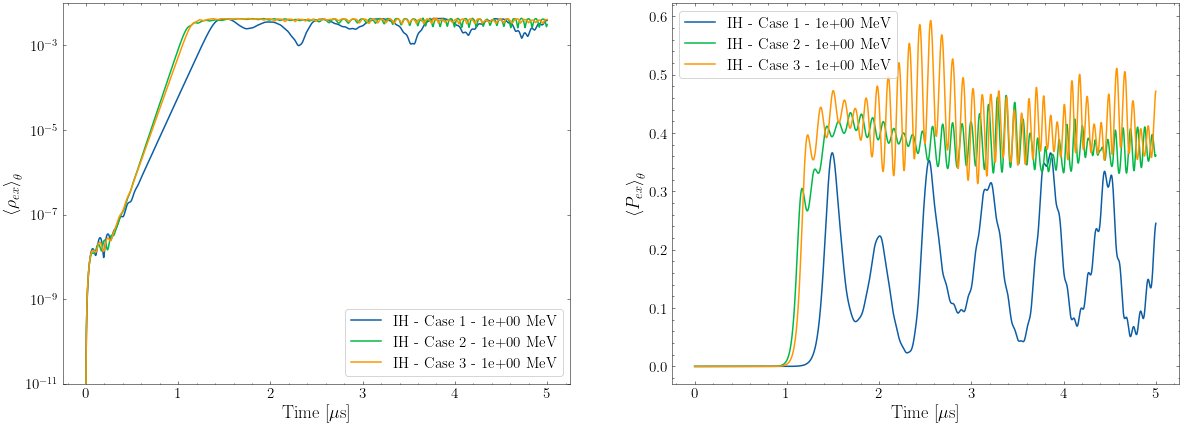

In [118]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
for i in range(len(scenarios)):
    plt.plot((10**6)*t,rho_ex_mean_time[i],label="%s - Case %d - %.0e MeV"%(scenarios[i][0],scenarios[i][1],scenarios[i][2]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
plt.ylim(10**-11,10**-2)
plt.yscale('log')

plt.subplot(1,2,2)
for i in range(len(scenarios)):
    plt.plot((10**6)*t,P_ex_mean_time[i],label="%s - Case %d - %.0e MeV"%(scenarios[i][0],scenarios[i][1],scenarios[i][2]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()

# 2.3 - Without Slow ($\omega= 0$) <a class="anchor" id="2.3-bullet"></a>

In [48]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["IH",'D',1,delta_m2_31],["IH",'D',1,0],["NH",'D',1,delta_m2_31],["NH",'D',1,0]]
# scenarios=[["IH",1,1]]
mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,5*10**(-6) #s
theta_bins=100
theta_step=np.pi/theta_bins
cos_theta_step=2/theta_bins

In [49]:
nu,nubar=[],[]
for mass_ord,case,E_nu,delta_m2 in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v2(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord)
    print("Took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)

Took 0.5820328195889791 minutes
Took 0.7702363332112631 minutes
Took 0.7841674327850342 minutes
Took 0.7724833488464355 minutes


In [54]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]

D_z1_time=[]
cos_theta_vec=np.linspace(1,-1,theta_bins)

for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu,(0,1,2,4,3))[i][0][0]**2+np.transpose(nu,(0,1,2,4,3))[i][1][0]**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
#     rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*theta_step/np.pi)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*cos_theta_step/2)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu,(0,1,2,4,3))[i][2][0][j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
#     P_ex_mean_time.append(sum(P_ex_theta_time_aux)*theta_step/np.pi)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*cos_theta_step/2)
    
    D_z1_time_aux=0
    for j in range(theta_bins):
        D_z1_time_aux=D_z1_time_aux+cos_theta_vec[j]*(np.transpose(nu,(0,1,2,4,3))[i][2][0][j]-np.transpose(nubar,(0,1,2,4,3))[i][2][0][j])*cos_theta_step
    D_z1_time.append(D_z1_time_aux)

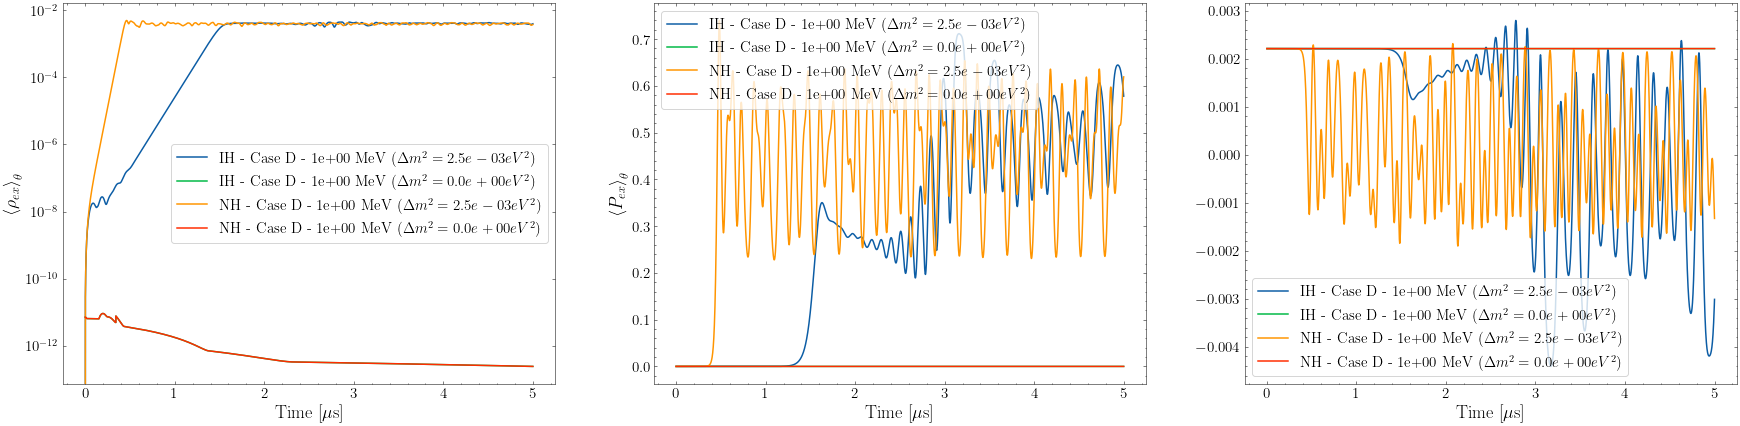

In [55]:
x_min,x_max=0,5*10**-6

plt.figure(figsize=(30,7))
plt.subplot(1,3,1)
for i in range(len(scenarios)):
    plt.plot((10**6)*t,rho_ex_mean_time[i],label="%s - Case %s - %.0e MeV ($\Delta m^2=%.1e eV^2$)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
# plt.ylim(10**-11,10**-2)
plt.yscale('log')

plt.subplot(1,3,2)
for i in range(len(scenarios)):
    plt.plot((10**6)*t,P_ex_mean_time[i],label="%s - Case %s - %.0e MeV ($\Delta m^2=%.1e eV^2$)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()

plt.subplot(1,3,3)
for i in range(len(scenarios)):
    plt.plot((10**6)*t,D_z1_time[i],label="%s - Case %s - %.0e MeV ($\Delta m^2=%.1e eV^2$)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
# plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()

In [45]:
mu_0=10**3 #km⁻¹
print("mu=",mu_0*10**(-3),"1/m")
print("mu=",mu_0*10**(-3)*c_const,"1/s")
print("1/mu=",1/(mu_0*10**(-3)*c_const),"s")
print("100/mu=",100/(mu_0*10**(-3)*c_const),"s")

mu= 1.0 1/m
mu= 299792458.0 1/s
1/mu= 3.3356409519815204e-09 s
100/mu= 3.3356409519815204e-07 s


# 3.Comparing Numerical Solvers <a class="anchor" id="3-bullet"></a>

In [8]:
def func_Collective_nu_v3(time,y, params):
    omega,E,theta_V,mu_0,n_f,n_dim,n_theta,cos_theta_vec= params  # unpack parameters
    B=np.array(B_vec(n_dim,theta_V))
    L=np.array(L_vec(n_dim))
    mu=mu_0
    lamb=lambda_supernova(time,"no",0)

    derivs=[]
    nu, nubar = from_1D_to_MultiD(y,n_f,n_dim,n_theta)
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,0,1))
    nubar_aux=np.transpose(nubar,(2,0,1))

    for i in range(n_dim):
      nu_sum.append(sum(map(sum,nu_aux[i])))
      nubar_sum.append(sum(map(sum,nubar_aux[i])))
      nu_sum_theta.append(sum(cos_theta_vec*list(map(sum,nu_aux[i]))))
      nubar_sum_theta.append(sum(cos_theta_vec*list(map(sum,nubar_aux[i]))))
    
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-cos_theta_vec[i]*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-cos_theta_vec[i]*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [9]:
def solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver):
    y0,omega,E,t,mu_0,n_f,n_dim,n_theta,cos_theta_vec=initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case)
    
    if mass_ord=="NH": 
        params=omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    elif mass_ord=="IH":
        params=-1*omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    else:
        print("Not a mass ordering option!")
    if solver=="odeint":
        y_sol= odeint(func_Collective_nu_v2, y0, t, args=(params,))
    else:
        psoln= solve_ivp(func_Collective_nu_v3,t_span=[t[0],t[-1]] ,y0=y0, method=solver, args=(params,),t_eval=t,atol=8e-10)
#         psoln= solve_ivp(func_Collective_nu_v3,t_span=[t[0],t[-1]] ,y0=y0, method=solver, args=(params,),t_eval=t)
        y_sol=np.transpose(psoln.y)
        t=psoln.t
    nu, nubar= read_output(y_sol,(n_f,n_dim,n_theta))    
    t=t/(c_const*from_eV_to_1_over_m) #From eV⁻¹ to km

    return cos_theta_vec,t,mu_0, nu, nubar

# 3.1 - With Slow ($\omega \neq 0$) <a class="anchor" id="3.2-bullet"></a>

In [10]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
# scenarios=[["NH",1,10,"RK45"],["NH",1,10,"LSODA"],["NH",1,10,"DOP853"],["NH",1,10,"Radau"],["NH",1,10,"BDF"],["NH",1,10,"odeint"]]
scenarios=[["NH",1,10,"RK45"],["NH",1,10,"DOP853"],["NH",1,10,"Radau"],["NH",1,10,"odeint"]]
# scenarios=[["NH",1,1,"RK45"],["NH",1,1,"odeint"]]
mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,5*10**(-6) #s
theta_bins=100
theta_step=np.pi/theta_bins
cos_theta_step=2/theta_bins

In [ ]:
nu,nubar=[],[]
t_vec=[]
for mass_ord,case,E_nu,solver in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver)
    print("Took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)
    t_vec.append(t)

In [ ]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]
for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu[i][0][0])**2+np.transpose(nu[i][1][0])**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*cos_theta_step/2)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu[i][2][0])[j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*cos_theta_step/2)

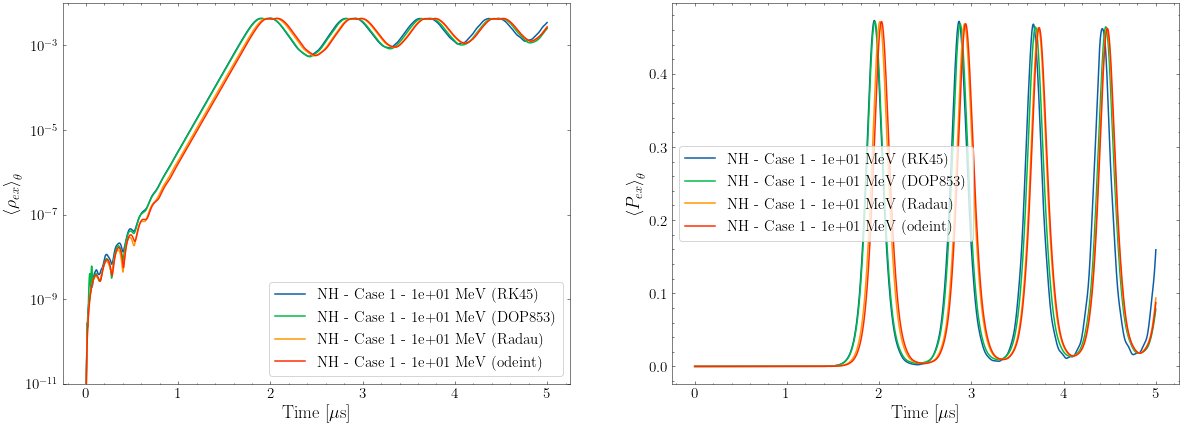

In [81]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
for i in range(len(scenarios)):
    plt.plot((10**6)*t_vec[i],rho_ex_mean_time[i],label="%s - Case %d - %.0e MeV (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
plt.ylim(10**-11,10**-2)
plt.yscale('log')

plt.subplot(1,2,2)
for i in range(len(scenarios)):
    plt.plot((10**6)*t_vec[i],P_ex_mean_time[i],label="%s - Case %d - %.0e MeV (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()

# 3.2 - Without Slow ($\omega= 0$) <a class="anchor" id="3.2-bullet"></a>

In [18]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["NH",1,10,"RK45",delta_m2_31],["NH",1,10,"DOP853",delta_m2_31],["NH",1,10,"odeint",delta_m2_31],["NH",1,10,"Radau",delta_m2_31],
          ["NH",1,10,"RK45",0],["NH",1,10,"DOP853",0],["NH",1,10,"odeint",0],["NH",1,10,"Radau",0]]
mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,5*10**(-6) #s
theta_bins=100
theta_step=np.pi/theta_bins
cos_theta_step=2/theta_bins

In [19]:
nu,nubar=[],[]
t_vec=[]
for mass_ord,case,E_nu,solver,delta_m2 in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver)
    print("Took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)
    t_vec.append(t)

Took 0.4685209314028422 minutes
Took 0.45777318477630613 minutes
Took 0.502572218577067 minutes
Took 12.586665681997935 minutes
Took 38.5495086312294 minutes
Took 0.4409048000971476 minutes
Took 0.766046400864919 minutes
Took 0.4407767136891683 minutes


In [20]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]
for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu[i][0][0])**2+np.transpose(nu[i][1][0])**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*cos_theta_step/2)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu[i][2][0])[j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*cos_theta_step/2)

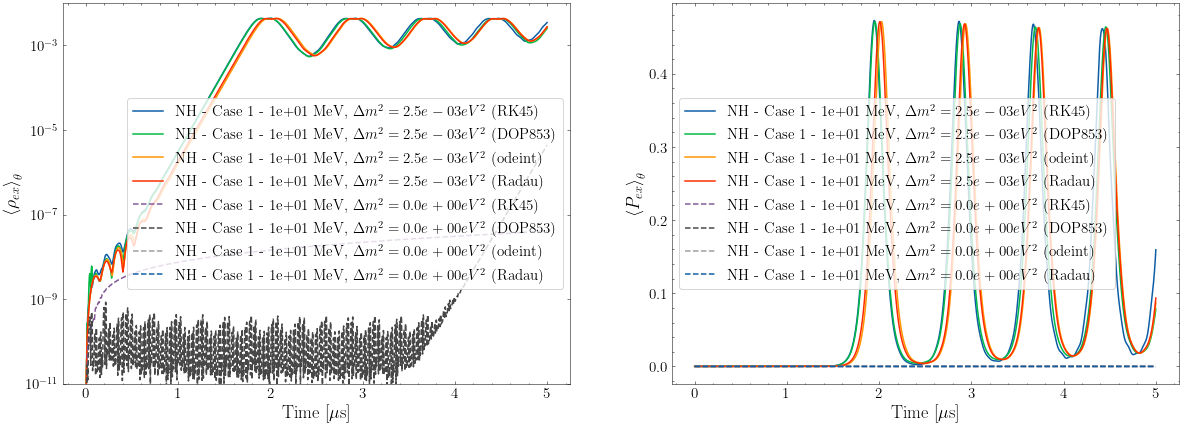

In [21]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
for i in range(len(scenarios)):
    if scenarios[i][4]==0:
        plt.plot((10**6)*t_vec[i],rho_ex_mean_time[i],ls='--',label="%s - Case %d - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
    else:
        plt.plot((10**6)*t_vec[i],rho_ex_mean_time[i],label="%s - Case %d - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
plt.ylim(10**-11,10**-2)
plt.yscale('log')

plt.subplot(1,2,2)
for i in range(len(scenarios)):
    if scenarios[i][4]==0:
        plt.plot((10**6)*t_vec[i],P_ex_mean_time[i],ls='--',label="%s - Case %d - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
    else:
        plt.plot((10**6)*t_vec[i],P_ex_mean_time[i],label="%s - Case %d - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()

In [10]:
def solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver):
    y0,omega,E,t,mu_0,n_f,n_dim,n_theta,cos_theta_vec=initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case)
    
    if mass_ord=="NH": 
        params=omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    elif mass_ord=="IH":
        params=-1*omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    else:
        print("Not a mass ordering option!")
    if solver=="odeint":
        y_sol= odeint(func_Collective_nu_v2, y0, t, args=(params,),atol=1e-9)
    else:
        psoln= solve_ivp(func_Collective_nu_v3,t_span=[t[0],t[-1]] ,y0=y0, method=solver, args=(params,),t_eval=t,atol=1e-9)
#         psoln= solve_ivp(func_Collective_nu_v3,t_span=[t[0],t[-1]] ,y0=y0, method=solver, args=(params,),t_eval=t)
        y_sol=np.transpose(psoln.y)
        t=psoln.t
    nu, nubar= read_output(y_sol,(n_f,n_dim,n_theta))    
    t=t/(c_const*from_eV_to_1_over_m) #From eV⁻¹ to km

    return cos_theta_vec,t,mu_0, nu, nubar

In [11]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["NH",1,10,"RK45",0],["NH",1,10,"DOP853",0],["NH",1,10,"odeint",0],["NH",1,10,"Radau",0],["NH",1,10,"BDF",0]]
# scenarios=[["NH",1,10,"RK45",0],["NH",1,10,"DOP853",0],["NH",1,10,"odeint",0]]
mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,10*10**(-6) #s
theta_bins=100
theta_step=np.pi/theta_bins
cos_theta_step=2/theta_bins

In [12]:
nu,nubar=[],[]
t_vec=[]
for mass_ord,case,E_nu,solver,delta_m2 in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver)
    print(solver," took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)
    t_vec.append(t)

RK45  took 1.0615097006162009 minutes
DOP853  took 0.9979001998901367 minutes
odeint  took 1.1781654119491578 minutes
Radau  took 14.660822463035583 minutes
BDF  took 5.339061852296194 minutes


In [13]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]
for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu[i][0][0])**2+np.transpose(nu[i][1][0])**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*cos_theta_step/2)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu[i][2][0])[j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*cos_theta_step/2)

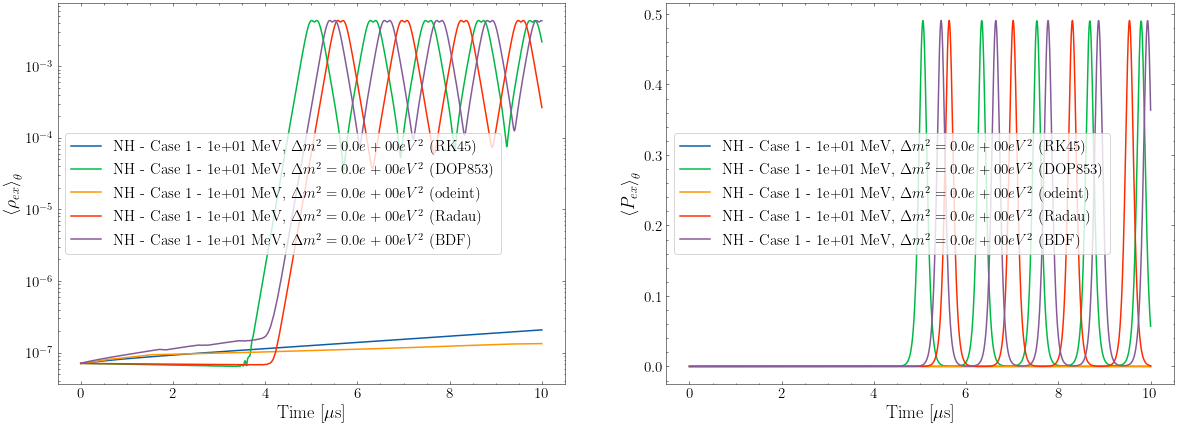

In [14]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
for i in range(len(scenarios)):
    plt.plot((10**6)*t_vec[i],rho_ex_mean_time[i],label="%s - Case %d - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
# plt.ylim(7.0710678e-8,7.07106785e-8)
# plt.xlim(0,0.01)
plt.yscale('log')

plt.subplot(1,2,2)
for i in range(len(scenarios)):
    plt.plot((10**6)*t_vec[i],P_ex_mean_time[i],label="%s - Case %d - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()

# 3.3 - Using *DifferentialEquations.jl*

# 3.4 - Ian Paper

In [12]:
def solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver):
    y0,omega,E,t,mu_0,n_f,n_dim,n_theta,cos_theta_vec=initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case)
    
    if mass_ord=="NH": 
        params=omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    elif mass_ord=="IH":
        params=-1*omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    else:
        print("Not a mass ordering option!")
    if solver=="odeint":
        y_sol= odeint(func_Collective_nu_v2, y0, t, args=(params,),atol=1e-9)
    else:
        psoln= solve_ivp(func_Collective_nu_v3,t_span=[t[0],t[-1]] ,y0=y0, method=solver, args=(params,),t_eval=t,atol=1e-9)
#         psoln= solve_ivp(func_Collective_nu_v3,t_span=[t[0],t[-1]] ,y0=y0, method=solver, args=(params,),t_eval=t)
        y_sol=np.transpose(psoln.y)
        t=psoln.t
    nu, nubar= read_output(y_sol,(n_f,n_dim,n_theta))    
    t=t/(c_const*from_eV_to_1_over_m) #From eV⁻¹ to km

    return cos_theta_vec,t,mu_0, nu, nubar

In [18]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["NH","A",10,"DOP853",0],["NH","B",10,"DOP853",0],["NH","C",10,"DOP853",0]]
# scenarios=[["NH","B",100,"DOP853",0],["NH","D",100,"DOP853",0]]
mu_0=10**5 #km⁻¹
mu_s=mu_0*10**(-3)*c_const #1/s
print("mu =",mu_s," 1/s")
mu_0=mu_0/from_eV_to_1_over_km #eV


#Numerical Solver Info
t_i,t_f=0,50000/mu_s #s
print("t_f =",t_f," s")
theta_bins=100
theta_step=np.pi/theta_bins
cos_theta_step=2/theta_bins

mu = 29979245800.0  1/s
t_f = 1.6678204759907602e-06  s


In [19]:
nu,nubar=[],[]
t_vec=[]
for mass_ord,case,E_nu,solver,delta_m2 in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver)
    print(solver,",",case," took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)
    t_vec.append(t)

DOP853 , A  took 9.272378849983216 minutes
DOP853 , B  took 11.829448366165161 minutes
DOP853 , C  took 13.581498948733012 minutes


In [20]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]
for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu[i][0][0])**2+np.transpose(nu[i][1][0])**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*cos_theta_step/2)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu[i][2][0])[j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*cos_theta_step/2)

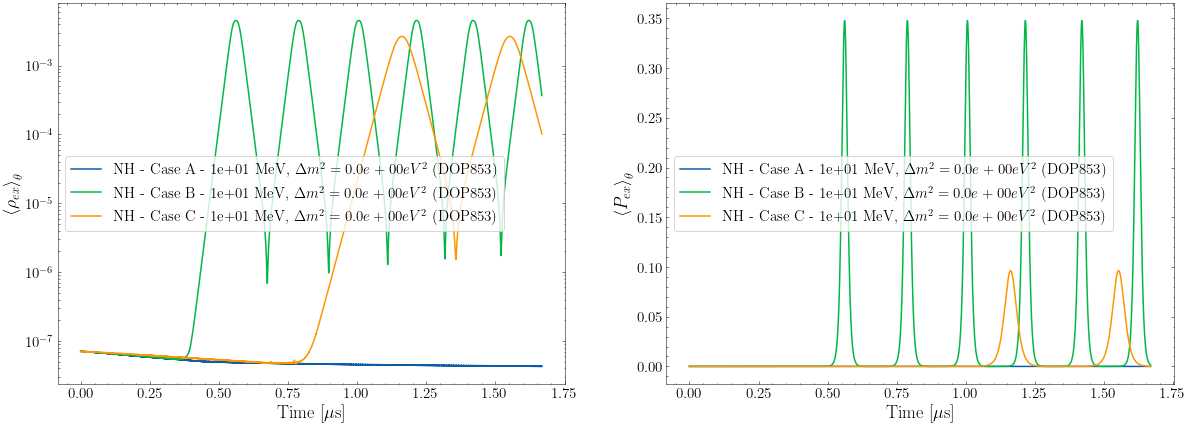

In [21]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
for i in range(len(scenarios)):
    plt.plot((10**6)*t_vec[i],rho_ex_mean_time[i],label="%s - Case %s - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
plt.yscale('log')

plt.subplot(1,2,2)
for i in range(len(scenarios)):
    plt.plot((10**6)*t_vec[i],P_ex_mean_time[i],label="%s - Case %s - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
# plt.xlim(0.5,1.2)
plt.legend()

# Draft <a class="anchor" id="draft-bullet"></a>

## Crossing parameter

$$\zeta = \mu_0 \frac{I_1(r)I_2(r)}{I_1(r)+I_2(r)}$$

$$I_1(r) = \int [ \rho_{ee}(r,\cos\theta) - \overline \rho_{ee}(r,\cos\theta)] d\cos\theta \text{, for }  \rho_{ee}(r,\cos\theta) > \overline \rho_{ee}(r,\cos\theta)\\
I_2(r) = \int  [\overline\rho_{ee}(r,\cos\theta) - \rho_{ee}(r,\cos\theta)] d\cos\theta \text{, for }  \rho_{ee}(r,\cos\theta) < \overline \rho_{ee}(r,\cos\theta)$$

In [56]:
def from_P_to_rho(P):
    rho_ee=1/2*(1+P[2])
    rho_ex=1/2*np.sqrt(P[0]**2+P[1]**2)
    return rho_ee,rho_ex

In [57]:
def zeta(rho_ee,rho_bar_ee,cos_theta_step,mu_0):
    I1=0
    I2=0
    for i in range(len(rho_ee)):
        if rho_ee>rho_bar_ee:
            I1=I1+(rho_ee[i]-rho_bar_ee[i])*cos_theta_step
        else:
            I2=I2+(rho_ee[i]-rho_bar_ee[i])*cos_theta_step
    return mu_0*I1*I2/(I1+I2)

In [62]:
print(len(nu[0][0][0][0]))

100


In [ ]:
rho_ee_theta_time=[]
rho_ex_theta_time=[]
rho_bar_ee_theta_time=[]
rho_bar_ex_theta_time=[]

for i in range(len(scenarios)):
    np.transpose(nu,(0,1,2,4,3))[i][0][0]